In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model

from keras2.layers import concatenate, Dense, Input, Flatten, merge
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym
from rl2.agents import DDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym.make("Pendulum-v0")

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [29]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    critic.summary()
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="sigmoid")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    actor.summary()
    return actor

def normal_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    actor = Model(inputs=action_input, outputs=x1)
    actor.summary()
    return actor
    

# どうやって学習率を変える？

def agent2(a_shape, s_shape):
    actor = normal_actor(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = DDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01,
        batch_size = 128,
    )
    return agent

In [4]:
a = agent2((1,),(3,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=['mae'])




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 3)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Sha

In [10]:
step = 100000
episode_step = 200 # 入力が加えられる回数を200(dt=0.05)にする
a.fit(env, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 72s 7ms/step - reward: -2.0025
50 episodes - episode_reward: -400.497 [-1496.989, -7.657] - loss: 32.737 - mean_absolute_error: 3.690 - mean_q: -8.677

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -1.3267
50 episodes - episode_reward: -265.348 [-1318.213, -9.609] - loss: 29.422 - mean_absolute_error: 2.770 - mean_q: 28.350

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -2.2017
50 episodes - episode_reward: -440.350 [-1656.659, -1.836] - loss: 25.233 - mean_absolute_error: 2.679 - mean_q: 37.020

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -1.0148
50 episodes - episode_reward: -202.969 [-1493.838, -4.083] - loss: 23.581 - mean_absolute_error: 2.591 - mean_q: 38.446

Interval 5 (40000 steps performed)
100

In [18]:
a.fit(env, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 73s 7ms/step - reward: -0.7859
50 episodes - episode_reward: -157.174 [-364.695, -5.732] - loss: 5.374 - mean_absolute_error: 1.117 - mean_q: 27.980

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 75s 7ms/step - reward: -0.7936
50 episodes - episode_reward: -158.720 [-367.264, -3.527] - loss: 4.676 - mean_absolute_error: 1.027 - mean_q: 24.326

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 71s 7ms/step - reward: -0.7236
50 episodes - episode_reward: -144.730 [-360.340, -6.048] - loss: 3.673 - mean_absolute_error: 0.960 - mean_q: 19.708

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 80s 8ms/step - reward: -0.8023
50 episodes - episode_reward: -160.467 [-373.223, -4.344] - loss: 2.947 - mean_absolute_error: 0.881 - mean_q: 15.321

Interval 5 (40000 steps performed)
10000/10000

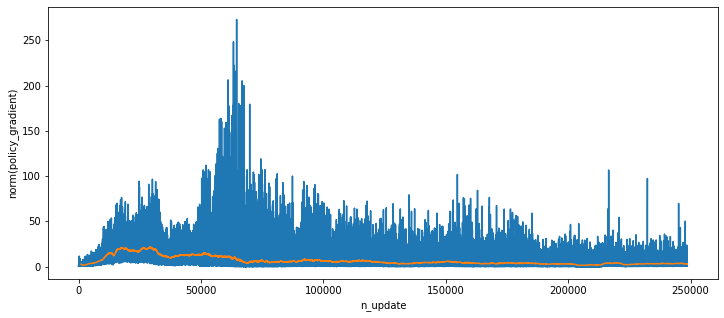

In [22]:
grads = a.gradient_log
ma_t = 1000
ma = moving_average(grads, ma_t)
plt.figure(figsize=(12,5))
plt.plot(grads)
plt.plot(range(ma_t, len(grads)), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

(248656,)


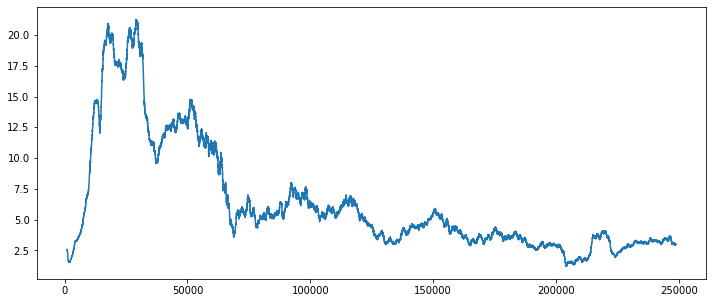

In [24]:
plt.figure(figsize=(12,5))
plt.plot(range(ma_t, len(grads)), ma)
plt.show()

In [28]:
a.test(env, nb_episodes=1, visualize=0, nb_max_episode_steps=200)

Testing for 1 episodes ...
Episode 1: reward: -132.868, steps: 200


In [30]:
ag = agent2((1,),(3,))
ag.compile(Adam(lr=0.001, clipnorm=1.), metrics=['mae'])

step = 200000
episode_step = 200 # 入力が加えられる回数を200(dt=0.05)にする
ag.fit(env, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 3)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape 

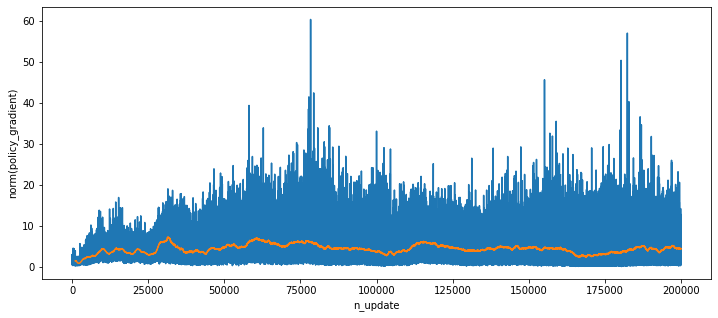

In [31]:
grads = ag.gradient_log
ma_t = 1000
ma = moving_average(grads, ma_t)
plt.figure(figsize=(12,5))
plt.plot(grads)
plt.plot(range(ma_t, len(grads)), ma)
plt.ylabel('norm(policy_gradient)')
plt.xlabel('n_update')
plt.show()

In [35]:
ag.test(env, nb_episodes=5, visualize=0, nb_max_episode_steps=200)

Testing for 5 episodes ...
Episode 1: reward: -132.537, steps: 200
Episode 2: reward: -398.751, steps: 200
Episode 3: reward: -399.818, steps: 200
Episode 4: reward: -130.925, steps: 200
Episode 5: reward: -124.643, steps: 200
